# Tutorial 8: Batch training strategy (pyG framework)

This tutorial demonstrates how to train STAGATE in batches on Slide-seqV2 data using STAGATE based on pyG (PyTorch Geometric) framework.

Benefit from the optimization of the pyG package for training graph neural networks, it is more than 10x faster than STAGATE based on the tensorflow1 framework, and can use a batch training strategy to deal with large-scale data.

The download and installation of the STAGATE package based on the pyG framework can be found at https://github.com/zhanglabtools/STAGATE_pyG.

In this tutorial, we foucs on the Slide-seqV2 mouse olfactory bulb data (Puck_200127_15 from https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2#study-summary).

We removed spots outside the main tissue area, and the used spots can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

## Strategies for dividing subgraphs

Because we build the spatial network based on spatial location, our network can be directly divided into subgraphs in the following form.

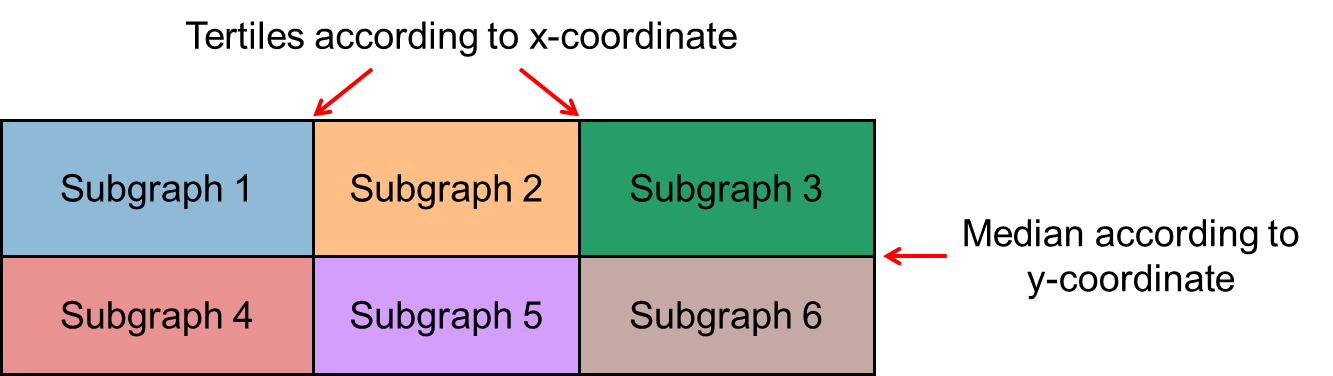

The above picture is an example of num_batch_x=3, num_batch_y=2. Specifically, we divide subgraphs according to quantiles on a single spatial coordinate.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm

In [2]:
import torch
import STAGATE_pyG
import torch.nn.functional as F

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
input_dir = 'Data'
counts_file = os.path.join(input_dir, 'Puck_200127_15.digital_expression.txt')
coor_file = os.path.join(input_dir, 'Puck_200127_15_bead_locations.csv')

In [5]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, index_col=0)
print(counts.shape, coor_df.shape)

(21220, 21724) (21724, 2)


In [6]:
adata = sc.AnnData(counts.T)
adata.var_names_make_unique()
coor_df = coor_df.loc[adata.obs_names, ['xcoord', 'ycoord']]
adata.obsm["spatial"] = coor_df.to_numpy()

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 21724 × 21220
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

(-289.81710000000004, 6312.7151, 173.30850000000004, 5709.8615)

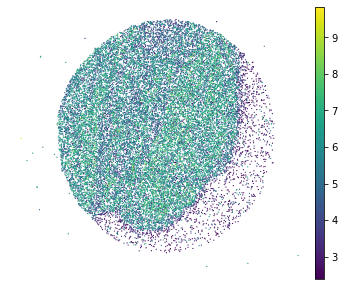

In [9]:
plt.rcParams["figure.figsize"] = (6,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=6, show=False)
plt.title('')
plt.axis('off')

In [10]:
# can be downloaded from https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing
used_barcode = pd.read_csv('Data/used_barcodes.txt', sep='\t', header=None)
used_barcode = used_barcode[0]

In [11]:
adata = adata[used_barcode,]

(588.545, 5108.555, 847.6700000000001, 5670.73)

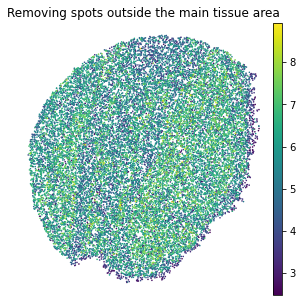

In [12]:
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="log1p_total_counts",s=10, show=False, title='Removing spots outside the main tissue area')

plt.axis('off')

In [13]:
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)

Trying to set attribute `.var` of view, copying.


After flitering:  (20139, 11750)


In [14]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [15]:
# Different with STAGATE (tensorflow version)
adata = adata[:,adata.var['highly_variable']]
adata.shape

(20139, 3000)

## Dividing subgraphs

In [16]:
adata.obs['X'] = adata.obsm['spatial'][:,0]
adata.obs['Y'] = adata.obsm['spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [17]:
# grid setting
num_batch_x = 3
num_batch_y = 2

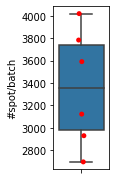

In [18]:
Batch_list = STAGATE_pyG.Batch_Data(adata, num_batch_x=num_batch_x, num_batch_y=num_batch_y, 
                                    spatial_key=['X', 'Y'], plot_Stats=True)

## Constructing the spatial network

In [19]:
# Consturcting network for each batch
for temp_adata in Batch_list:
    STAGATE_pyG.Cal_Spatial_Net(temp_adata, rad_cutoff=50)
    #STAGATE_pyG.Stats_Spatial_Net(temp_adata)

------Calculating spatial graph...


Trying to set attribute `._uns` of view, copying.


The graph contains 41528 edges, 3782 cells.
10.9804 neighbors per cell on average.
------Calculating spatial graph...


Trying to set attribute `._uns` of view, copying.


The graph contains 32236 edges, 2931 cells.
10.9983 neighbors per cell on average.
------Calculating spatial graph...


Trying to set attribute `._uns` of view, copying.


The graph contains 41060 edges, 3590 cells.
11.4373 neighbors per cell on average.
------Calculating spatial graph...


Trying to set attribute `._uns` of view, copying.


The graph contains 33970 edges, 3123 cells.
10.8774 neighbors per cell on average.
------Calculating spatial graph...


Trying to set attribute `._uns` of view, copying.


The graph contains 29512 edges, 2698 cells.
10.9385 neighbors per cell on average.
------Calculating spatial graph...


Trying to set attribute `._uns` of view, copying.


The graph contains 45606 edges, 4017 cells.
11.3532 neighbors per cell on average.


In [20]:
data_list = [STAGATE_pyG.Transfer_pytorch_Data(adata) for adata in Batch_list]
for temp in data_list:
    temp.to(device)

In [21]:
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=50)
data = STAGATE_pyG.Transfer_pytorch_Data(adata)

------Calculating spatial graph...
The graph contains 228300 edges, 20139 cells.
11.3362 neighbors per cell on average.


## DataLoader for bathces

In [22]:
from torch_geometric.loader import DataLoader

# batch_size=1 or 2
loader = DataLoader(data_list, batch_size=1, shuffle=True)

## Running STAGATE

In [23]:
# hyper-parameters
num_epoch = 1000
lr=0.001
weight_decay=1e-4
hidden_dims = [512, 30]

In [24]:
model = STAGATE_pyG.STAGATE(hidden_dims = [data_list[0].x.shape[1]]+hidden_dims).to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [25]:
for epoch in tqdm(range(1, num_epoch+1)):
    for batch in loader:
        model.train()
        optimizer.zero_grad()
        z, out = model(batch.x, batch.edge_index)
        loss = F.mse_loss(batch.x, out) #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
        optimizer.step()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.14it/s]


In [26]:
# The total network
data.to(device)

Data(x=[20139, 3000], edge_index=[2, 248439])

In [27]:
model.eval()
z, out = model(data.x, data.edge_index)

STAGATE_rep = z.to('cpu').detach().numpy()
adata.obsm['STAGATE'] = STAGATE_rep

## Clustering and UMAP

In [28]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [29]:
sc.tl.louvain(adata, resolution=0.5)

(588.545, 5108.555, 847.6700000000001, 5670.73)

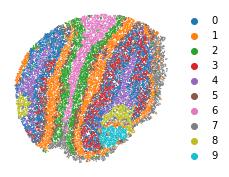

In [30]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color="louvain",s=6, show=False)#, legend_loc=False)
plt.title('')
plt.axis('off')

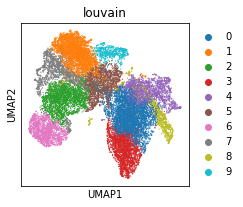

In [31]:
sc.pl.umap(adata, color='louvain')